In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import statsmodels.api as sm 
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from re import sub
%matplotlib inline

# Loading housing data, data cleaning, feature engineering

In [3]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
prices_df = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()

In [4]:
#Create series of continuous variable names

cont_vars = pd.Series(['saleprice', 'yrsold', 'miscval', 'poolarea','screenporch', 'threessnporch', 'enclosedporch',
                             'wooddecksf', 'openporchsf','garagearea', 'garageyrblt', 'grlivarea', 'lowqualfinsf', 'firstflrsf', 
                             'secondflrsf','totalbsmtsf', 'bsmtunfsf', 'bsmtfinsf1', 'bsmtfinsf2', 'masvnrarea', 
                             'yearbuilt', 'yearremodadd','lotarea', 'lotfrontage'])

#Create series of the categorical variable names

cat_vars = []

for var in prices_df.columns:
    if cont_vars.str.contains(var).any() == False:
        cat_vars.append(var)

cat_vars = pd.Series(cat_vars)

#Check that no variables are in both variable lists

for var in prices_df.columns:
    if cont_vars.str.contains(var).any() & cat_vars.str.contains(var).any():
        print(var)

In [5]:
#Convert categorical variables to numerically coded categories

coded_df = prices_df.copy()
coded_df.sort_values(by='saleprice')
codebook = {}

for var in cat_vars:
    if  coded_df[var].dtype == 'O':
        
        #Create replace dict for each variable
        labels = coded_df[var].unique()
        replace_dict = {k: v for k,v in zip(labels,range(len(labels)))}
        
        #Add var entry to codebook and replace in dataframe
        codebook.update({var: replace_dict})
        coded_df.loc[:,var] = coded_df[var].replace(replace_dict) 

In [6]:
#Boxcox transform our dependent variable, add to list of cont_vars 

coded_df['boxcox_saleprice'] = stats.boxcox(coded_df['saleprice'])[0]
cont_vars = list(cont_vars)
cont_vars.insert(0,'boxcox_saleprice')

In [7]:
#Sort variables by their relevance in the model

#Loop through cat_vars and conduct One-Way Anova across the groups in each cat_var for boxcox_saleprice

import statsmodels.api as sm
from statsmodels.formula.api import ols
F = []
p = []

for var in cat_vars:
    mod_str = 'boxcox_saleprice ~ ' + var
    mod = ols(mod_str, data=coded_df).fit()
    aov_table= sm.stats.anova_lm(mod, typ=2)
    F.append(aov_table['F'][0])
    p.append(aov_table['PR(>F)'][0])
    
#Save results of anova in df with variable names

aov_res = pd.DataFrame(cat_vars, columns=['var'])
aov_res['F'] = F
aov_res['p-value'] = p 
aov_res.sort_values(by='F', ascending=False, inplace=True)

#Create correlation matrix, sort by saleprice
cont_corrs = coded_df[cont_vars].corr()
cont_corrs.sort_values(by='boxcox_saleprice',axis=0, ascending=False, inplace=True)

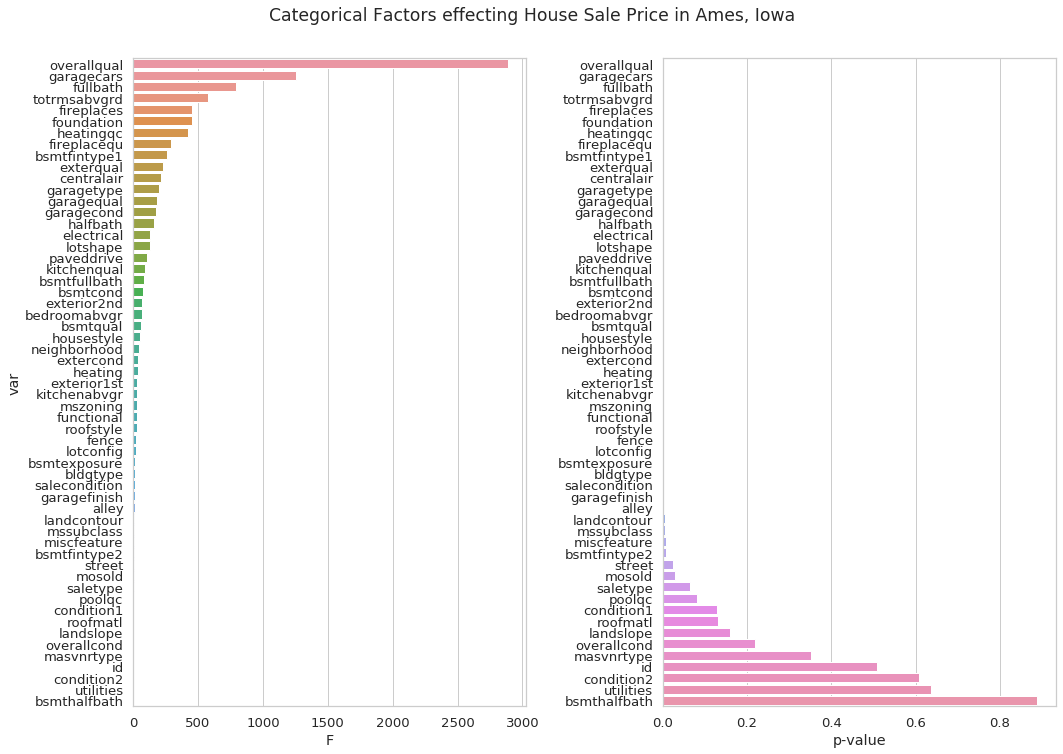

In [10]:
plt.figure(figsize=(15,10))
sns.set(font_scale=1.2, style='whitegrid')

plt.subplot(1,2,1)
sns.barplot(x='F', y='var', data=aov_res)

plt.subplot(1,2,2)
sns.barplot(x='p-value', y='var', data=aov_res)
plt.ylabel('')

plt.suptitle('Categorical Factors effecting House Sale Price in Ames, Iowa', y=1.05)
plt.tight_layout()
plt.show()

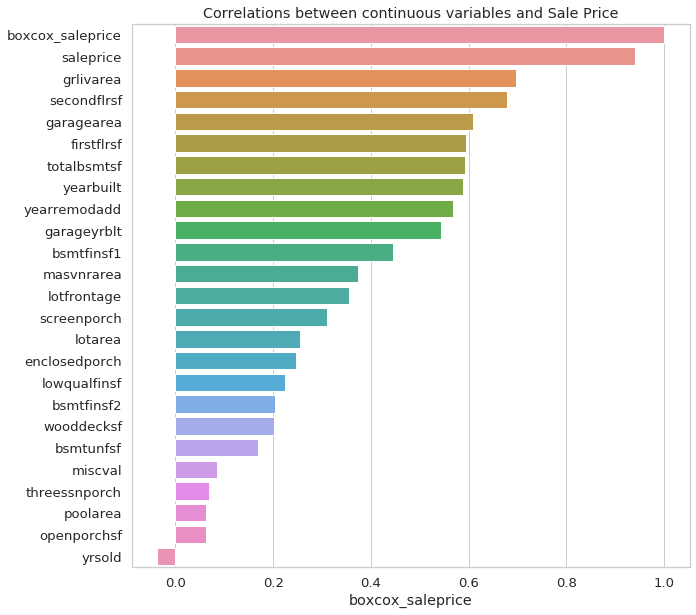

In [13]:
#Plot continuous data to see distributions, replace 0's with np.nan to avoid skewing data
nan_df = coded_df.copy()

for i in range(len(cont_vars)):
    nan_df.loc[:,cont_vars[i]] = nan_df[cont_vars[i]].replace(0,np.nan)

#Create correlation matrix, sort by saleprice
cont_corrs = nan_df[cont_vars].corr()
cont_corrs.sort_values(by='boxcox_saleprice',axis=0, ascending=False, inplace=True)

#Plot correlations for boxcox_saleprice 
plt.figure(figsize=(10,10))

sns.barplot(y=cont_corrs.index, x=cont_corrs.loc[:,'boxcox_saleprice'])
plt.title('Correlations between continuous variables and Sale Price')
plt.show()

In [129]:
#Create series of top 10 categorical variables
features = aov_res['var'][:20]

#Append series of continuous variables with greater than 0.5 correlation and remove saleprice vars and secondflrsf
cont_features = list(cont_corrs.loc[cont_corrs['boxcox_saleprice']>0.5, 'boxcox_saleprice'].index)
for var in ['boxcox_saleprice', 'saleprice']: cont_features.remove(var) 
    
features = features.append(pd.Series(cont_features), ignore_index=True)

In [22]:
coded_df.loc[:,features] = coded_df.loc[:,features].fillna(0)

# OLS Regression

In [28]:
#Sort data into dependent and independent variables
Y = coded_df['boxcox_saleprice']
X = coded_df[features]

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=2)

lrm = LinearRegression(fit_intercept=True)

lrm.fit(X_train, y_train)

# We are making predictions here

y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in training set is: 0.8468891991204972
-----Test set statistics-----
R-squared of the model in test set is: 0.8503741988220439
Mean absolute error of the prediction is: 0.043405251219756094
Mean squared error of the prediction is: 0.0037654271402474265
Root mean squared error of the prediction is: 0.061363076359056724
Mean absolute percentage error of the prediction is: 0.557114139633144


# Ridge Regression

In [29]:
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]
ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(X_train, y_train)

y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 10.0
R-squared of the model in training set is: 0.8467666022593752
-----Test set statistics-----
R-squared of the model in test set is: 0.8501843480257487
Mean absolute error of the prediction is: 0.04328582550024841
Mean squared error of the prediction is: 0.00377020485462115
Root mean squared error of the prediction is: 0.06140199389776484
Mean absolute percentage error of the prediction is: 0.5555920476708859


/home/derek/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# Lasso Regression

In [35]:
lasso_cv = LassoCV(alphas=alphas, cv=5, fit_intercept=True, tol=0.01)

lasso_cv.fit(X_train, y_train)

y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 0.0001
R-squared of the model in training set is: 0.8468521808468371
-----Test set statistics-----
R-squared of the model in test set is: 0.8503617158974259
Mean absolute error of the prediction is: 0.04334271161847119
Mean squared error of the prediction is: 0.003765741280875421
Root mean squared error of the prediction is: 0.061365635993407754
Mean absolute percentage error of the prediction is: 0.5563407659068323


# ElasticNet Regression

In [37]:
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5, fit_intercept=True, tol=0.01)

elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 0.001
R-squared of the model in training set is: 0.8459601585581489
-----Test set statistics-----
R-squared of the model in test set is: 0.8495956719337345
Mean absolute error of the prediction is: 0.04324715477441147
Mean squared error of the prediction is: 0.003785019257726995
Root mean squared error of the prediction is: 0.06152251017088781
Mean absolute percentage error of the prediction is: 0.5551960795714218


# Model selection and additional features

Ridge regression performed best; however all models performed similarly well. The model does not appear to be overfitting as the model performs nearly identically on the train and test sets.

## Additional features

Let's add per capita income per year in Ames, Iowa as well as the All-Transactions House Price Index values per year in Ames.

In [53]:
per_capita_income = pd.read_csv('Data/per_capita_income.csv')
per_capita_income.head()

,Date,US,Iowa,Ames
0,2017,"$32,397","$30,865","$30,490"
1,2016,"$31,798","$30,693","$28,538"
2,2015,"$31,019","$29,621","$28,186"
3,2014,"$29,942","$29,395","$26,301"
4,2013,"$29,706","$29,238","$26,521"


In [54]:
#See which years houses were sold in original dataset

print('Houses were sold between ' + str(coded_df.yrsold.min()) + ' and ' + str(coded_df.yrsold.max()))

Houses were sold between 2006 and 2010


In [94]:
# Convert currency string to int
for i in range(len(per_capita_income.Ames)):
    per_capita_income.loc[i,'Ames'] = int(sub(r'[^\d.]', '', per_capita_income.Ames[i]))

In [130]:
#Create replace dict to add per capita income to each year in the dataset
replace_dict = {}

for year in coded_df.yrsold.unique():
    replace_dict.update({year: per_capita_income.loc[per_capita_income.Date == year, 'Ames'].values[0]})  
    
#Add per capita income into coded_df

coded_df['income'] = coded_df['yrsold']
coded_df['income'] = coded_df['income'].replace(replace_dict)

#Insert new feature into features list
features = features.append(pd.Series('income'), ignore_index=True)

In [114]:
ames_hpi = pd.read_csv('Data/ames_hpi.csv')
ames_hpi.columns = ['date', 'hpi']
ames_hpi.head()

,date,hpi
0,1986-10-01,67.45
1,1987-01-01,67.74
2,1987-04-01,70.16
3,1987-07-01,69.02
4,1987-10-01,68.92


In [124]:
#Add years column and average house price index per year

ames_hpi['year'] = ames_hpi['date']

for i in range(len(ames_hpi.year)):
    ames_hpi.loc[i,'year'] = int(ames_hpi.loc[i,'year'][:4])
    
for year in ames_hpi.year.unique():
    ames_hpi.loc[ames_hpi.year == year, 'hpi'] = ames_hpi.loc[ames_hpi.year == year, 'hpi'].mean()

In [131]:
#Create replace dict to add per capita income to each year in the dataset
replace_dict = {}

for year in coded_df.yrsold.unique():
    replace_dict.update({year: ames_hpi.loc[ames_hpi.year == year, 'hpi'].values[0]})  
    
#Add per capita income into coded_df

coded_df['hpi'] = coded_df['yrsold']
coded_df['hpi'] = coded_df['hpi'].replace(replace_dict)

#Insert new feature into features list
features = features.append(pd.Series('hpi'), ignore_index=True)

# Ridge Regression with new features

In [132]:
#Sort data into dependent and independent variables
Y = coded_df['boxcox_saleprice']
X = coded_df[features]

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=2)

ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(X_train, y_train)

y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 10.0
R-squared of the model in training set is: 0.8469077420632704
-----Test set statistics-----
R-squared of the model in test set is: 0.8504490871727244
Mean absolute error of the prediction is: 0.04332985021167043
Mean squared error of the prediction is: 0.003763542527928424
Root mean squared error of the prediction is: 0.06134771819659166
Mean absolute percentage error of the prediction is: 0.5562185371804257


/home/derek/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [133]:
res_df = pd.DataFrame(features, columns=['feature'])
res_df['coeff'] = ridge_cv.coef_
res_df

,feature,coeff
0,overallqual,3.327789e-02
1,garagecars,2.113313e-02
2,fullbath,8.979778e-03
3,totrmsabvgrd,7.525983e-03
4,fireplaces,2.127893e-02
5,foundation,-5.819212e-03
6,heatingqc,-8.464152e-03
7,fireplacequ,2.320614e-03
8,bsmtfintype1,-1.368698e-03
9,exterqual,-4.046674e-03


# Summary

The new features led to extremely small improvements in the ridge regression model. The housing price index seems to be a good addition to the model as it has a relatively large coefficient when compared to some of the other features, the income feature has the smallest coefficient of any features and can probably be removed without any ill effects.